In [702]:
import cv2
import imutils
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from skimage.filters import threshold_local

In [703]:

class ShapeDetector:
	def __init__(self):
		pass

	def predict_shape(self, c):
		
		shape = "unidentified"
		peri = cv2.arcLength(c, True)
		approx = cv2.approxPolyDP(c, 0.04 * peri, True)
		# if the shape is a triangle, it will have 3 vertices
		if len(approx) == 3:
			shape = "triangle"
		# if the shape has 4 vertices, it is either a square or
		# a rectangle
		elif len(approx) == 4:
			# compute the bounding box of the contour and use the
			# bounding box to compute the aspect ratio
			(x, y, w, h) = cv2.boundingRect(approx)
			ar = w / float(h)
			# a square will have an aspect ratio that is approximately
			# equal to one, otherwise, the shape is a rectangle
			shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
		# if the shape is a pentagon, it will have 5 vertices
		elif len(approx) == 5:
			shape = "pentagon"
		# otherwise, we assume the shape is a circle
		else:
			shape = "circle"
	
		return shape
	
	def detect_shapes(self, image):
		
		resized = imutils.resize(image, width=100)
		ratio = image.shape[0] / float(resized.shape[0])
		gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
		#blurred = cv2.GaussianBlur(gray, (7, 7), 0)
		#thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)[1]
		thresh = cv2.bitwise_not(gray)
		cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
			cv2.CHAIN_APPROX_SIMPLE)
		cnts = imutils.grab_contours(cnts)

		image_copy = image.copy()

		for c in cnts:
			
			M = cv2.moments(c)
			if M["m00"] > 0:
				cX = int((M["m10"] / M["m00"]) * ratio)
				cY = int((M["m01"] / M["m00"]) * ratio)
				shape = self.predict_shape(c)
				c = c.astype("float")
				c *= ratio
				c = c.astype("int")
				cv2.drawContours(image_copy, [c], -1, (0, 255, 0), 5)
				cv2.putText(image_copy, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX,
					0.5, (0, 0, 255), 2)
		
		return image_copy
			


In [704]:

class Preprocessing:

    def __init__(self) -> None:
        pass

    def shadow_remove(self, img):
            rgb_planes = cv2.split(img)
            result_norm_planes = []
            for plane in rgb_planes:
                dilated_img = cv2.dilate(plane, np.ones((17,17), np.uint8))
                bg_img = cv2.medianBlur(dilated_img, 21)
                diff_img = 255 - cv2.absdiff(plane, bg_img)
                norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
                result_norm_planes.append(norm_img)
            shadowremov = cv2.merge(result_norm_planes)
            return shadowremov

    def order_points(self,pts):
        # initialzie a list of coordinates that will be ordered
        # such that the first entry in the list is the top-left,
        # the second entry is the top-right, the third is the
        # bottom-right, and the fourth is the bottom-left
        rect = np.zeros((4, 2), dtype = "float32")
        # the top-left point will have the smallest sum, whereas
        # the bottom-right point will have the largest sum
        s = pts.sum(axis = 1) 
        rect[0] = pts[np.argmin(s)] 
        rect[2] = pts[np.argmax(s)] 
        # now, compute the difference between the points, the
        # top-right point will have the smallest difference,
        # whereas the bottom-left will have the largest difference
        diff = np.diff(pts, axis = 1)
        rect[1] = pts[np.argmin(diff)] 
        rect[3] = pts[np.argmax(diff)] 
        # return the ordered coordinates
        return rect
    
    def four_point_transform(self,image, pts):

        # obtain a consistent order of the points and unpack them
        # individually
        rect = self.order_points(pts)
        (tl, tr, br, bl) = rect 
        # compute the width of the new image, which will be the
        # maximum distance between bottom-right and bottom-left
        # x-coordiates or the top-right and top-left x-coordinates
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2)) 
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))
        # compute the height of the new image, which will be the
        # maximum distance between the top-right and bottom-right
        # y-coordinates or the top-left and bottom-left y-coordinates
        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))
        # now that we have the dimensions of the new image, construct
        # the set of destination points to obtain a "birds eye view",
        # (i.e. top-down view) of the image, again specifying points
        # in the top-left, top-right, bottom-right, and bottom-left
        # order
        dst = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]], dtype = "float32")
        # compute the perspective transform matrix and then apply it
        M = cv2.getPerspectiveTransform(rect, dst)
        warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
        # return the warped image
        return warped
    
    def scan_image(self, image):
           
        ratio = image.shape[0] / 2000.0
        orig = image.copy()
        image = imutils.resize(image, height = 2000)
        
        #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(image, (5, 5), 0)
        edged = cv2.Canny(gray, 75, 240)

        cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
        # loop over the contours
        for c in cnts:
            # approximate the contour
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)
            # if our approximated contour has four points, then we
            # can assume that we have found our screen
            if len(approx) == 4:
                screenCnt = approx
                break
        # show the contour (outline) of the piece of paper
        cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)

        warped = self.four_point_transform(orig, screenCnt.reshape(4, 2) * ratio )
        T = threshold_local(warped, 9, offset = 11, method = "gaussian")
        warped = (warped > T).astype("uint8") * 255
        warped = warped[20:-20,20:-20]

        return warped

True

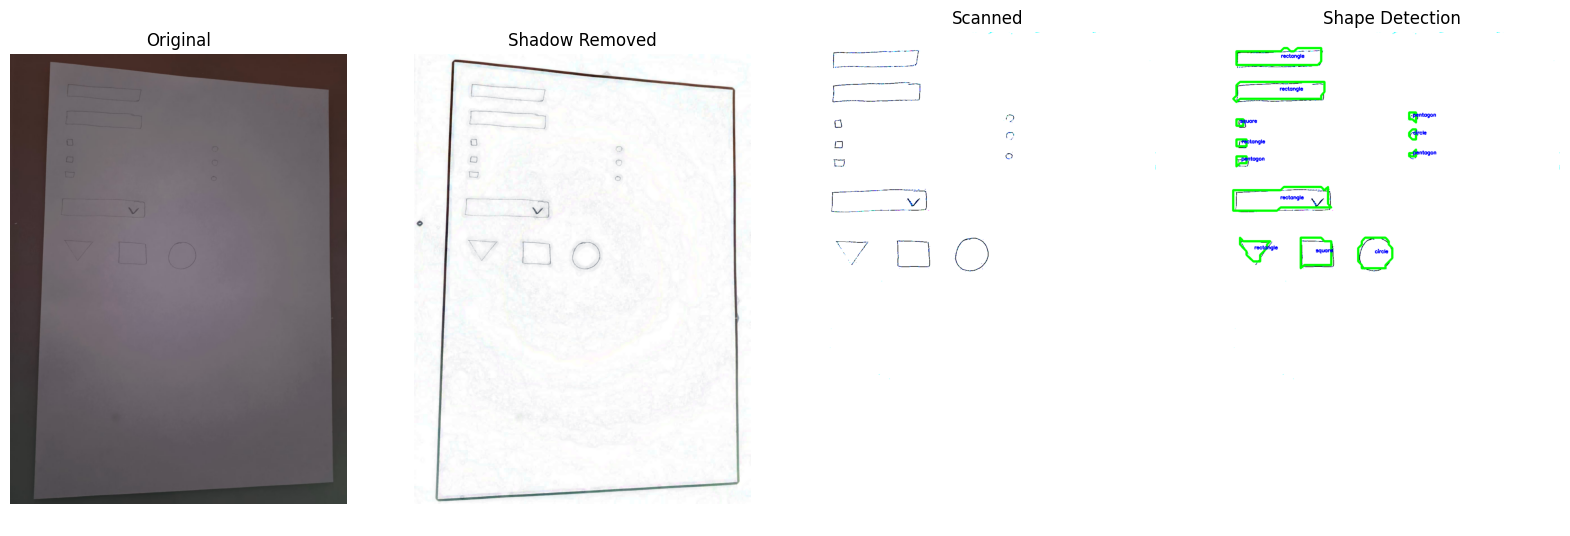

In [707]:
filename = "1.jpg"
image = cv2.imread(filename)

preprocessing = Preprocessing()
sd = ShapeDetector()

img_shadow_removed = preprocessing.shadow_remove(image)
img_scanned = preprocessing.scan_image(img_shadow_removed)
img_shape_detected = sd.detect_shapes(img_scanned)

fig = plt.figure(figsize=(20, 30))

figures = { "Original": image,
			"Shadow Removed": img_shadow_removed,
			"Scanned": img_scanned,
			"Shape Detection": img_shape_detected}

for i,key in enumerate(figures):

	fig.add_subplot(2, 4, i+1)
	plt.imshow(figures[key])
	plt.axis('off')
	plt.title(key)

cv2.imwrite(filename+"_detection.jpg",img_shape_detected)
